# WiDS 2025 Datathon Competition

- Adapted from: WiDS Datathon 2025 Workshop at New England Microsoft Research

- Event Organizers: Sharut Gupta (MIT CSAIL), Arushi Jain (Microsoft), Claire Tinker (IBM)

- Objective: Predicting both an individual’s sex and their ADHD diagnosis using functional brain imaging data of children and adolescents and their socio-demographic, emotions, and parenting information (https://www.kaggle.com/competitions/widsdatathon2025)

- Data Source: You can download the data ("train.csv" and "test.csv") from the Kaggle competition (https://www.kaggle.com/competitions/widsdatathon2024-challenge2/data)

### #1. Load Necessary Libraries and Data

In [1]:
# Install required packages (run this only if needed)
!pip install -q kaggle
!pip install -q pandas numpy scikit-learn torch matplotlib xgboost seaborn
!pip install -q openpyxl

# Standard libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

# Model building
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Utility
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# === Load TRAIN data ===
train_path = "wids_data/TRAIN_NEW"
connectome_train = pd.read_csv(f"{train_path}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quant_meta_train = pd.read_excel(f"{train_path}/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat_meta_train = pd.read_excel(f"{train_path}/TRAIN_CATEGORICAL_METADATA_new.xlsx")
targets_train = pd.read_excel(f"{train_path}/TRAINING_SOLUTIONS.xlsx")

# Check shapes
print("Connectome:", connectome_train.shape)
print("Quantitative metadata:", quant_meta_train.shape)
print("Categorical metadata:", cat_meta_train.shape)
print("Targets:", targets_train.shape)


# === Load TEST data ===
test_path = "wids_data/TEST"
connectome_test = pd.read_csv(f"{test_path}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
quant_meta_test = pd.read_excel(f"{test_path}/TEST_QUANTITATIVE_METADATA.xlsx")
cat_meta_test = pd.read_excel(f"{test_path}/TEST_CATEGORICAL.xlsx")

Connectome: (1213, 19901)
Quantitative metadata: (1213, 19)
Categorical metadata: (1213, 10)
Targets: (1213, 3)


### #2. Exploratory Data Analysis

In [10]:
cat_meta_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1170 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1159 non-null   float64
 5   MRI_Track_Scan_Location           1210 non-null   float64
 6   Barratt_Barratt_P1_Edu            1198 non-null   float64
 7   Barratt_Barratt_P1_Occ            1182 non-null   float64
 8   Barratt_Barratt_P2_Edu            1015 non-null   float64
 9   Barratt_Barratt_P2_Occ            991 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 94.9+ KB


In [13]:
cat_meta_train['Barratt_Barratt_P2_Occ'].value_counts()

Barratt_Barratt_P2_Occ
45.0    239
35.0    195
30.0    149
40.0    116
15.0     86
0.0      65
20.0     41
5.0      38
10.0     37
25.0     25
Name: count, dtype: int64

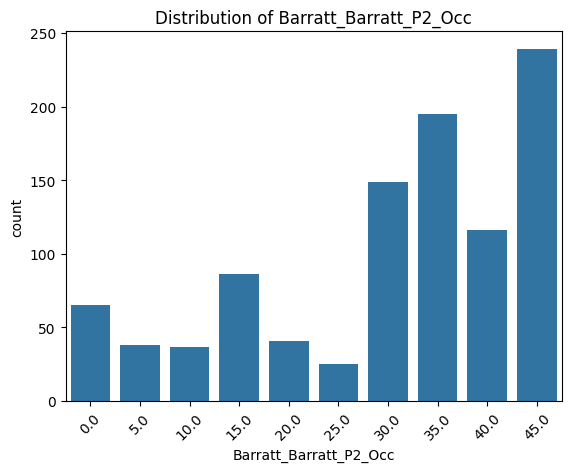

In [16]:
sns.countplot(x='Barratt_Barratt_P2_Occ', data=cat_meta_train[['Barratt_Barratt_P2_Occ']])
plt.title(f"Distribution of Barratt_Barratt_P2_Occ")
plt.xticks(rotation=45)
plt.show()

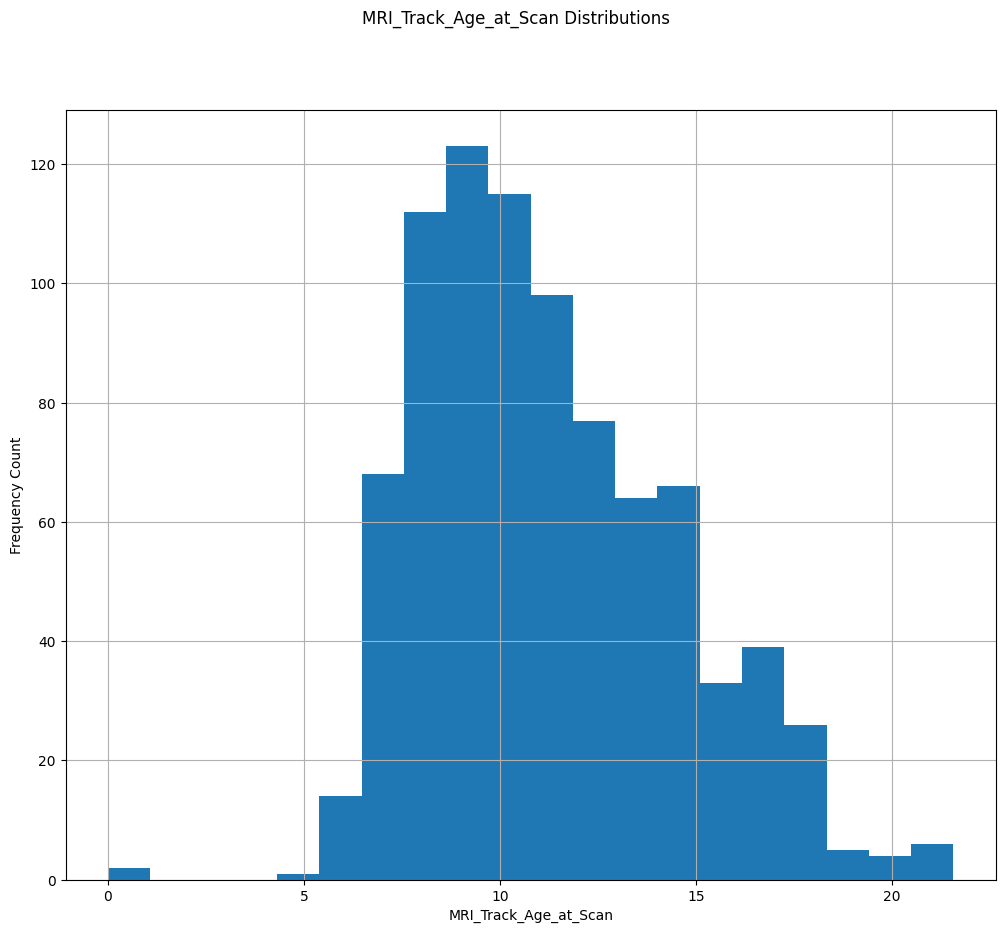

In [19]:
# Distribution of MRI_Track_Age_at_Scan
quant_meta_train['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()

In [22]:
targets_train['ADHD_Outcome'].value_counts()

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

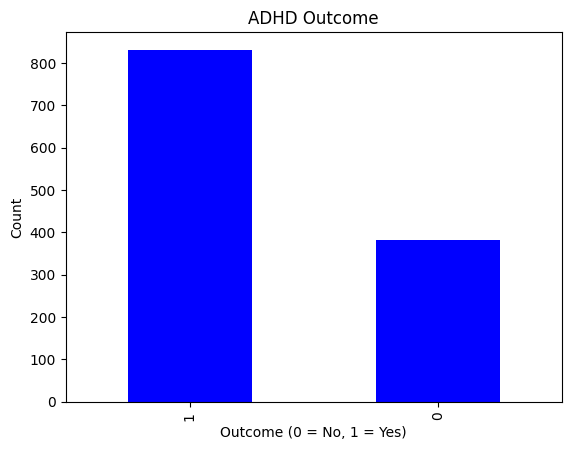

In [25]:
targets_train['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [28]:
# Gender distribution
targets_train['Sex_F'].value_counts()

Sex_F
0    797
1    416
Name: count, dtype: int64

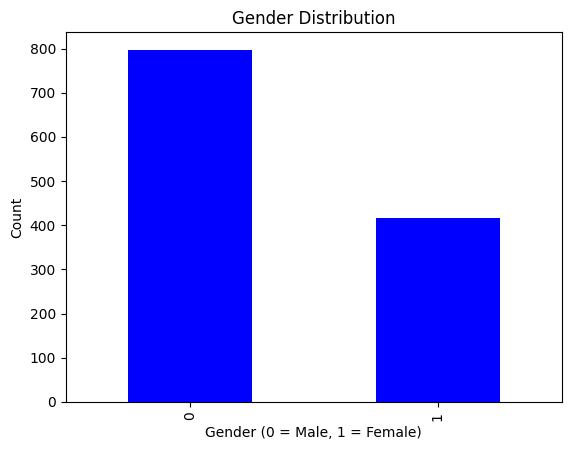

In [31]:
targets_train['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

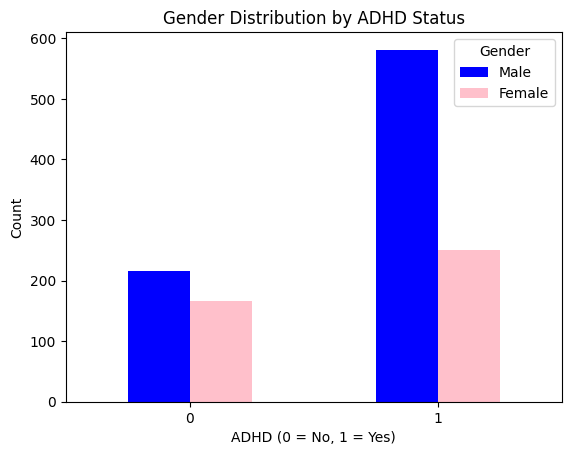

In [34]:
# Cross-tabulation of Gender and ADHD
gender_adhd_counts = pd.crosstab(targets_train['ADHD_Outcome'], targets_train['Sex_F'])

# Plot grouped bars
gender_adhd_counts.plot(kind='bar', color=['blue', 'pink'])  # Customize colors

plt.title('Gender Distribution by ADHD Status')
plt.xlabel('ADHD (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.legend(['Male', 'Female'], title='Gender')
plt.xticks(rotation=0)
plt.show()

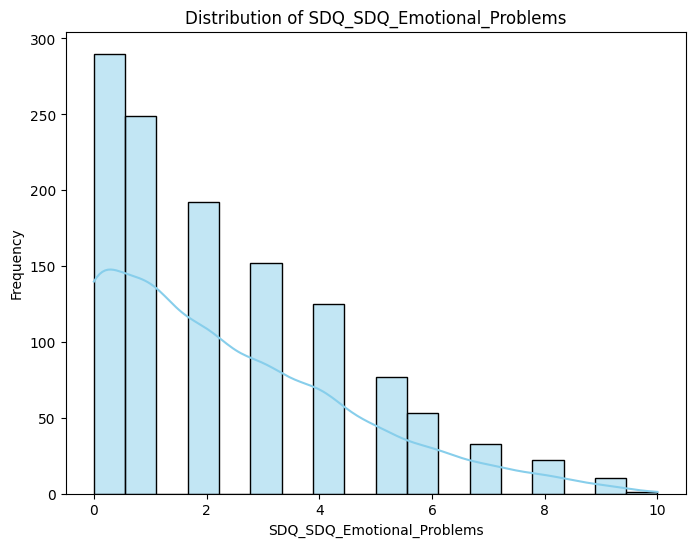

In [37]:
plt.figure(figsize=(8, 6))
sns.histplot(quant_meta_train['SDQ_SDQ_Emotional_Problems'], kde=True, color='skyblue')
plt.title('Distribution of SDQ_SDQ_Emotional_Problems')
plt.xlabel('SDQ_SDQ_Emotional_Problems')
plt.ylabel('Frequency')
plt.show()

In [40]:
cat_meta_train.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

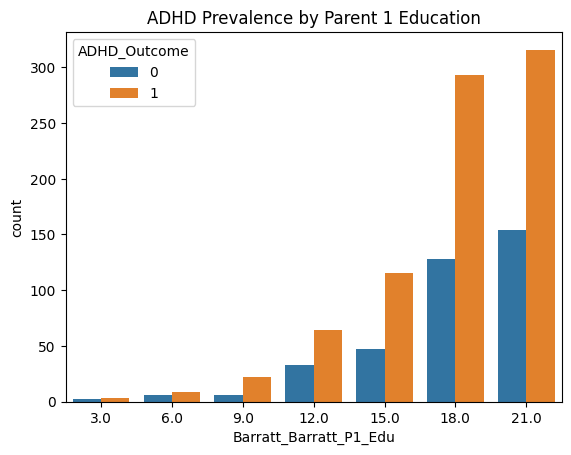

In [43]:
sns.countplot(data=cat_meta_train, x='Barratt_Barratt_P1_Edu', hue=targets_train['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 1 Education')
plt.show()

In [46]:
cat_meta_train['Barratt_Barratt_P1_Edu'].value_counts()

Barratt_Barratt_P1_Edu
21.0    470
18.0    421
15.0    162
12.0     97
9.0      28
6.0      15
3.0       5
Name: count, dtype: int64

In [49]:
cat_meta_train_copy = cat_meta_train.copy()
cat_meta_train_copy['ADHD_Outcome'] = targets_train['ADHD_Outcome']

adhd_percentages = cat_meta_train_copy.groupby('Barratt_Barratt_P1_Edu')['ADHD_Outcome'].mean()
print(adhd_percentages)

Barratt_Barratt_P1_Edu
3.0     0.600000
6.0     0.600000
9.0     0.785714
12.0    0.659794
15.0    0.709877
18.0    0.695962
21.0    0.672340
Name: ADHD_Outcome, dtype: float64


### #3. Data Pre-Processing

In [52]:
#one-hot encoding

for col in cat_meta_train.select_dtypes(include='int').columns:
    cat_meta_train[col] = cat_meta_train[col].astype('category')

# Creating a list of all of the columns except the first
columns_to_encode = cat_meta_train.columns[1:].tolist()

# Print the columns to encode
print("Columns to encode:", columns_to_encode)

Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


In [55]:
# encoding categorical data
train_encoded = pd.get_dummies(cat_meta_train[columns_to_encode], drop_first=True)
train_encoded = train_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))

In [58]:
# Combine encoded columns with the rest of the DataFrame
cat_train_final = pd.concat([cat_meta_train.drop(columns=columns_to_encode), train_encoded], axis=1)

# Make sure it looks correct
cat_train_final.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,NaN,NaN,0,0,0,1,0,0,0,1
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,1,0,0,0,0,0,0
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,NaN,NaN,0,1,0,0,0,0,0,0
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,1,0,0,0,0,0
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,NaN,NaN,0,0,1,0,0,0,0,0


In [61]:
# convert our int variables to categories
for col in cat_meta_test.select_dtypes(include='int').columns:
    cat_meta_test[col] = cat_meta_test[col].astype('category')

# Encode categorical variables in test
test_encoded = pd.get_dummies(cat_meta_test[columns_to_encode], drop_first=True)
test_encoded = test_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))

# Ensure test_encoded has the same columns as train_encoded
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0  # Add missing columns with 0 values

# Ensure test_encoded columns are in the same order as train_encoded
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Combine encoded columns with the rest of the DataFrame
cat_test_final = pd.concat([cat_meta_test.drop(columns=columns_to_encode), test_encoded], axis=1)

cat_test_final.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4
0,Cfwaf5FX7jWK,0.0,0.0,0,21.0,30.0,18.0,30.0,0,0,0,0,0,0,0,0
1,vhGrzmvA3Hjq,0.0,0.0,0,21.0,45.0,NaN,30.0,0,0,0,0,0,0,0,0
2,ULliyEXjy4OV,0.0,0.0,0,21.0,40.0,18.0,40.0,0,0,0,0,0,0,0,0
3,LZfeAb1xMtql,0.0,0.0,0,21.0,45.0,21.0,45.0,0,0,0,0,0,0,0,0
4,EnFOUv0YK1RG,2.0,0.0,0,18.0,0.0,21.0,45.0,0,0,0,0,0,0,0,0


In [64]:
# uncomment the below line when you actually run the notebook so that you have ALL three datasets merged 
# train_cat_FCM = pd.merge(cat_train_final, connectome_train, on = 'participant_id')
train_df = pd.merge(cat_train_final, quant_meta_train, on = 'participant_id')
train_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,NaN,NaN,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,1,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,NaN,NaN,0,1,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,NaN,NaN,0,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [67]:
# uncomment the below line when you actually run the notebook so that you have ALL three datasets merged 
# test_cat_FCM = pd.merge(cat_test_final, connectome_test, on = 'participant_id')
test_df = pd.merge(cat_test_final, quant_meta_test, on = 'participant_id')
test_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,0.0,0.0,0,21.0,30.0,18.0,30.0,0,0,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,0.0,0.0,0,21.0,45.0,NaN,30.0,0,0,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,0.0,0.0,0,21.0,40.0,18.0,40.0,0,0,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,0.0,0.0,0,21.0,45.0,21.0,45.0,0,0,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,2.0,0.0,0,18.0,0.0,21.0,45.0,0,0,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


In [70]:
#handling NA values
# desc = pd.DataFrame(index = list(train_df))
# desc['type'] = train_df.dtypes
# desc['count'] = train_df.count()
# desc['nunique'] = train_df.nunique()
# desc['%unique'] = desc['nunique'] /len(train_df) * 100
# desc['null'] = train_df.isnull().sum()
# desc['%null'] = desc['null'] / len(train_df) * 100
# desc = pd.concat([desc,train_df.describe().T.drop('count',axis=1)],axis=1)
# desc.sort_values(by=['type','null'],ascending=False).style.background_gradient(cmap='YlOrBr')\
#     .bar(subset=['mean'],color='green')\
#     .bar(subset=['max'],color='red')\
#     .bar(subset=['min'], color='purple')
print(train_df.isna().sum())
print(train_df.isna().sum().sum())

participant_id                        0
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
Basic_Demos_Enroll_Year_2016          0
Basic_Demos_Enroll_Year_2017          0
Basic_Demos_Enroll_Year_2018          0
Basic_Demos_Enroll_Year_2019          0
Basic_Demos_Enroll_Year_2020          0
Basic_Demos_Study_Site_2              0
Basic_Demos_Study_Site_3              0
Basic_Demos_Study_Site_4              0
EHQ_EHQ_Total                        13
ColorVision_CV_Score                 23
APQ_P_APQ_P_CP                       12
APQ_P_APQ_P_ID                       12
APQ_P_APQ_P_INV                      12
APQ_P_APQ_P_OPD                      12
APQ_P_APQ_P_PM                       12
APQ_P_APQ_P_PP                       12
SDQ_SDQ_Conduct_Problems              9


In [73]:
# Replace null values in all columns with nulls with the mean of the column for training data
for col in train_df.columns:
    if train_df[col].isna().sum() > 0:  # Check if the column has NaN values
        if train_df[col].dtype in ['float64', 'int64']:  # Ensure it's numeric
            train_df[col] = train_df[col].fillna(train_df[col].mean())  # Avoid inplace
        else:
            print(f"Skipping non-numeric column: {col}")

print(train_df.isna().sum().sum()) # should now be zero

0


In [76]:
# Replace null values in all columns with nulls with the mean of the column for testing data
for col in test_df.columns:
    if test_df[col].isna().sum() > 0:  # Check if the column has NaN values
        if test_df[col].dtype in ['float64', 'int64']:  # Ensure it's numeric
            test_df[col] = test_df[col].fillna(test_df[col].mean())  # Avoid inplace
        else:
            print(f"Skipping non-numeric column: {col}")

print(test_df.isna().sum().sum()) # should now be zero

0


### #4. XG Boost

In [79]:
X_train = train_df.drop(columns = ['participant_id'])
Y_train = targets_train.drop(columns = ['participant_id'])
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

In [82]:
# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

In [85]:
# Train the model
multioutput_classifier.fit(X_train, Y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


In [88]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.5}
Best score:  0.47023432983028945


### #5. Cross-Validation

In [94]:
def multi_output_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute accuracy for each target variable and return the mean
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

In [97]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)

In [100]:
# # Perform cross-validation on the training data
# cv_scores = cross_val_score(multioutput_classifier, X_train, Y_train, cv=5, scoring=multi_output_scorer)

# # Output the cross-validation results
# print("Cross-validation scores for each fold:", cv_scores)
# print("Mean CV score:", np.mean(cv_scores))

### #6. Logistic Regression for Feature Selection

In [103]:
model = LogisticRegression(max_iter=1000)
model.fit(train_df.drop(columns='participant_id'), targets_train['Sex_F'])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [104]:
# Get coefficients for Sex prediction
coefficients = pd.Series(model.coef_[0], index=train_df.drop(columns='participant_id').columns)

In [107]:
# Select top features for Sex prediction
top_features = coefficients.abs().nlargest(10)
print(top_features)

Basic_Demos_Enroll_Year_2018        0.565521
Basic_Demos_Enroll_Year_2016        0.473748
Basic_Demos_Enroll_Year_2019        0.331706
Basic_Demos_Enroll_Year_2017        0.325241
Basic_Demos_Study_Site_3            0.298452
Basic_Demos_Study_Site_4            0.265933
Basic_Demos_Enroll_Year_2020        0.123336
PreInt_Demos_Fam_Child_Ethnicity    0.115102
SDQ_SDQ_Prosocial                   0.072607
MRI_Track_Age_at_Scan               0.058195
dtype: float64


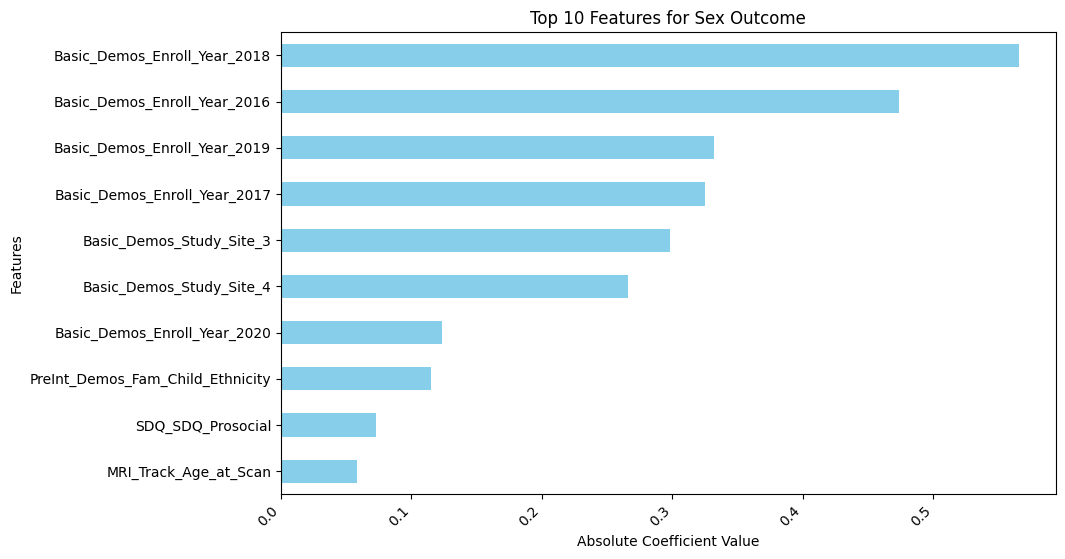

In [110]:
#Plotting the top 10 coefficents for Sex Outcome
plt.figure(figsize=(10,6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Features for Sex Outcome')
plt.ylabel('Features')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.show()

In [113]:
model = LogisticRegression(max_iter=1000)
model.fit(train_df.drop(columns='participant_id'), targets_train['ADHD_Outcome'])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [116]:
# Get coefficients for ADHD_Outcome prediction
coefficients = pd.Series(model.coef_[0], index=train_df.drop(columns='participant_id').columns)

In [119]:
# Select top features for ADHD_Outcome prediction
top_features = coefficients.abs().nlargest(10)
print(top_features)

Basic_Demos_Enroll_Year_2016    0.602039
Basic_Demos_Enroll_Year_2020    0.337879
Basic_Demos_Enroll_Year_2019    0.198314
Basic_Demos_Study_Site_3        0.197073
Basic_Demos_Study_Site_2        0.187910
MRI_Track_Scan_Location         0.148791
Basic_Demos_Enroll_Year_2018    0.119995
Basic_Demos_Study_Site_4        0.069328
Basic_Demos_Enroll_Year_2017    0.051333
SDQ_SDQ_Conduct_Problems        0.047858
dtype: float64


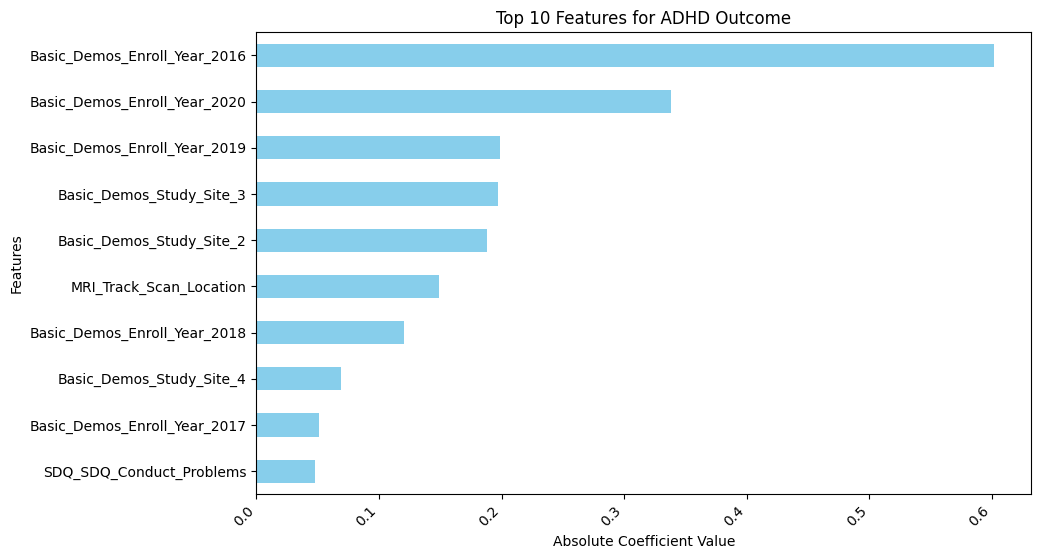

In [122]:
#Plotting the top 10 coefficents
plt.figure(figsize=(10,6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Features for ADHD Outcome')
plt.ylabel('Features')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.show()

### #7. Regularization

In [125]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(train_df.drop(columns='participant_id'), targets_train['Sex_F'])

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [128]:
selected_features_Sex = train_df.drop(columns='participant_id').columns[model.coef_[0] != 0]
print(selected_features_Sex)

Index(['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ',
       'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ',
       'Basic_Demos_Enroll_Year_2016', 'Basic_Demos_Enroll_Year_2017',
       'Basic_Demos_Enroll_Year_2018', 'Basic_Demos_Enroll_Year_2019',
       'Basic_Demos_Study_Site_3', 'Basic_Demos_Study_Site_4', 'EHQ_EHQ_Total',
       'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID',
       'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM',
       'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')


In [131]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(train_df.drop(columns='participant_id'), targets_train['ADHD_Outcome'])

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [134]:
selected_features_ADHD = train_df.drop(columns='participant_id').columns[model.coef_[0] != 0]
print(selected_features_ADHD)

Index(['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'Basic_Demos_Enroll_Year_2016',
       'Basic_Demos_Enroll_Year_2018', 'Basic_Demos_Enroll_Year_2019',
       'Basic_Demos_Study_Site_3', 'Basic_Demos_Study_Site_4', 'EHQ_EHQ_Total',
       'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID',
       'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'MRI_Track_Age_at_Scan'],
      dtype='object')


In [137]:
participant_id = test_df['participant_id']
X_test = test_df.drop(columns = 'participant_id')
y_pred = multioutput_classifier.predict(X_test)

In [143]:
# Step 1: Find common features between ADHD and Sex selected features
common_features = list(set(selected_features_ADHD) & set(selected_features_Sex))

X_train_2 = X_train[common_features]
X_test_2 = X_test[common_features]

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

# Train the model
multioutput_classifier.fit(X_train_2, Y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


In [146]:
y_pred_2 = multioutput_classifier.predict(X_test_2)

# Convert predictions to a DataFrame
predictions_df_2 = pd.DataFrame(
    y_pred_2,
    columns=['Predicted_Gender', 'Predicted_ADHD']
)

# Combine participant IDs with predictions
result_df_2 = pd.concat([participant_id.reset_index(drop=True), predictions_df_2], axis=1)

result_df_2.head()

,participant_id,Predicted_Gender,Predicted_ADHD
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,0,0


### #8. Validation and Testing

In [149]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)
# Perform cross-validation on the training data
cv_scores_2 = cross_val_score(multioutput_classifier, X_train_2, Y_train, cv=5, scoring=multi_output_scorer)
# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores_2)
print("Mean CV score:", np.mean(cv_scores_2))

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(
    y_pred,
    columns=['Predicted_Gender', 'Predicted_ADHD']
)
# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df], axis=1)
result_df

Cross-validation scores for each fold: [0.69547325 0.70576132 0.6872428  0.50619835 0.26446281]
Mean CV score: 0.5718277046559874


,participant_id,Predicted_Gender,Predicted_ADHD
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0
...,...,...,...
299,UadZfjdEg7eG,1,1
300,IUEHiLmQAqCi,1,0
301,cRySmCadYFRO,1,0
302,E3MvDUtJadc5,1,1


### #9. Loading Libraries and Data for Deep Learning

In [152]:
# Install required packages (run this only if needed)
!pip install -q kaggle
!pip install -q pandas numpy scikit-learn torch matplotlib
!pip install -q openpyxl

# Standard libraries
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Utility
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [155]:
# === Load TRAIN data ===
train_path = "wids_data/TRAIN_NEW"
connectome_train = pd.read_csv(f"{train_path}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quant_meta_train = pd.read_excel(f"{train_path}/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat_meta_train = pd.read_excel(f"{train_path}/TRAIN_CATEGORICAL_METADATA_new.xlsx")
targets_train = pd.read_excel(f"{train_path}/TRAINING_SOLUTIONS.xlsx")

# Check shapes
print("Connectome:", connectome_train.shape)
print("Quantitative metadata:", quant_meta_train.shape)
print("Categorical metadata:", cat_meta_train.shape)
print("Targets:", targets_train.shape)


# === Load TEST data ===
test_path = "wids_data/TEST"
connectome_test = pd.read_csv(f"{test_path}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
quant_meta_test = pd.read_excel(f"{test_path}/TEST_QUANTITATIVE_METADATA.xlsx")
cat_meta_test = pd.read_excel(f"{test_path}/TEST_CATEGORICAL.xlsx")

Connectome: (1213, 19901)
Quantitative metadata: (1213, 19)
Categorical metadata: (1213, 10)
Targets: (1213, 3)


In [158]:
#pre-processing and merging data 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def preprocess_data(connectome, quant_meta, cat_meta, targets=None, is_train=True, scaler=None, feature_columns=None):
    # Merge all inputs
    df = connectome.merge(quant_meta, on="participant_id").merge(cat_meta, on="participant_id")
    
    if is_train:
        df = df.merge(targets, on="participant_id")

    # Store IDs for debugging or tracking
    ids = df["participant_id"]
    df = df.drop(columns=["participant_id"])

    # Separate targets if available
    if is_train:
        y_adhd = df["ADHD_Outcome"]
        y_sex = df["Sex_F"]
        X = df.drop(columns=["ADHD_Outcome", "Sex_F"])
    else:
        y_adhd = y_sex = None
        X = df

    # Replace infs with NaNs
    X = X.replace([np.inf, -np.inf], np.nan)

    # Drop columns with >30% missing values (only in train)
    if is_train:
        missing_ratio = X.isnull().mean()
        to_drop = missing_ratio[missing_ratio > 0.3].index
        print(f"Dropping {len(to_drop)} columns with >30% missing values")
        X = X.drop(columns=to_drop)
    else:
        # Drop same columns as train
        X = X[feature_columns]

    # Separate types
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    # Impute
    if numeric_cols:
        imp_num = SimpleImputer(strategy='median')
        X[numeric_cols] = imp_num.fit_transform(X[numeric_cols]) if is_train else imp_num.fit(X[numeric_cols]).transform(X[numeric_cols])

    if categorical_cols:
        imp_cat = SimpleImputer(strategy='most_frequent')
        X[categorical_cols] = imp_cat.fit_transform(X[categorical_cols]) if is_train else imp_cat.fit(X[categorical_cols]).transform(X[categorical_cols])
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Align test with train
    if not is_train:
        X = X.reindex(columns=feature_columns, fill_value=0)

    # Scale
    if is_train:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    # Final safety check
    assert not np.isnan(X_scaled).any(), "NaNs in processed data!"
    assert not np.isinf(X_scaled).any(), "Infs in processed data!"

    return X_scaled, y_adhd, y_sex, scaler, X.columns.tolist()


In [161]:
# === Preprocess TRAIN ===
X_train_full, y_adhd, y_sex, scaler, feature_cols = preprocess_data(
    connectome=connectome_train,
    quant_meta=quant_meta_train,
    cat_meta=cat_meta_train,
    targets=targets_train,
    is_train=True
)

X_train, X_val, y_train_adhd, y_val_adhd, y_train_sex, y_val_sex = train_test_split(
    X_train_full, y_adhd, y_sex, test_size=0.1, random_state=42
)

# === Preprocess TEST ===
X_test, _, _, _, _ = preprocess_data(
    connectome=connectome_test,
    quant_meta=quant_meta_test,
    cat_meta=cat_meta_test,
    targets=None,
    is_train=False,
    scaler=scaler,
    feature_columns=feature_cols
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Dropping 0 columns with >30% missing values
Train shape: (1091, 19927)
Val shape: (122, 19927)
Test shape: (304, 19927)


### #10. PyTorch Dataset and Model

In [164]:
class BrainDataset(Dataset):
    def __init__(self, X, y1, y2):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y1 = torch.tensor(y1.values, dtype=torch.float32)
        self.y2 = torch.tensor(y2.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y1[idx], self.y2[idx]

### #11. Deep Neural Networks

In [167]:
class BrainNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.out_adhd = nn.Linear(128, 1)
        self.out_sex = nn.Linear(128, 1)

    def forward(self, x):
        feat = self.net(x)
        return self.out_adhd(feat).squeeze(1), self.out_sex(feat).squeeze(1)

### #12. Gradient Descent Overview

In [170]:
def evaluate(true, pred, label=""):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred, zero_division=0)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"{label:<6} → Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

def train_model(model, loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Use pos_weight to handle ADHD imbalance
    adhd_pos_weight = torch.tensor([y_train_adhd.value_counts()[0] / y_train_adhd.value_counts()[1]]).to(device)
    
    # Define separate losses
    loss_adhd = nn.BCEWithLogitsLoss(pos_weight=adhd_pos_weight)
    loss_sex = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for xb, yb1, yb2 in loader:
            xb, yb1, yb2 = xb.to(device), yb1.to(device), yb2.to(device)
            pred1, pred2 = model(xb)
            loss = loss_adhd(pred1, yb1) + loss_sex(pred2, yb2)
            total_loss += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            all_preds, all_trues = { "ADHD": [], "Sex": [] }, { "ADHD": [], "Sex": [] }
            for xb, yb1, yb2 in val_loader:
                xb = xb.to(device)
                p1, p2 = model(xb)
                all_preds["ADHD"].extend((torch.sigmoid(p1) > 0.5).cpu().numpy())
                all_preds["Sex"].extend((torch.sigmoid(p2) > 0.5).cpu().numpy())
                all_trues["ADHD"].extend(yb1.numpy())
                all_trues["Sex"].extend(yb2.numpy())

        print(f"\nEpoch {epoch+1} | Avg Loss: {total_loss/len(loader):.4f}")
        for label in ["ADHD", "Sex"]:
            evaluate(np.array(all_trues[label]), np.array(all_preds[label]), label)

In [173]:
train_ds = BrainDataset(X_train, y_train_adhd, y_train_sex)
val_ds = BrainDataset(X_val, y_val_adhd, y_val_sex)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

model = BrainNet(X_train.shape[1])
train_model(model, train_loader, val_loader, epochs=10)


Epoch 1 | Avg Loss: 1.1323
ADHD   → Acc: 0.5164 | Prec: 0.6981 | Recall: 0.4625 | F1: 0.5564
Sex    → Acc: 0.7213 | Prec: 0.6061 | Recall: 0.4878 | F1: 0.5405

Epoch 2 | Avg Loss: 0.6030
ADHD   → Acc: 0.6066 | Prec: 0.6860 | Recall: 0.7375 | F1: 0.7108
Sex    → Acc: 0.7295 | Prec: 0.6000 | Recall: 0.5854 | F1: 0.5926

Epoch 3 | Avg Loss: 0.3776
ADHD   → Acc: 0.5492 | Prec: 0.6404 | Recall: 0.7125 | F1: 0.6746
Sex    → Acc: 0.7049 | Prec: 0.5862 | Recall: 0.4146 | F1: 0.4857

Epoch 4 | Avg Loss: 0.1906
ADHD   → Acc: 0.6311 | Prec: 0.6842 | Recall: 0.8125 | F1: 0.7429
Sex    → Acc: 0.6967 | Prec: 0.5667 | Recall: 0.4146 | F1: 0.4789

Epoch 5 | Avg Loss: 0.1440
ADHD   → Acc: 0.6230 | Prec: 0.7024 | Recall: 0.7375 | F1: 0.7195
Sex    → Acc: 0.7459 | Prec: 0.6786 | Recall: 0.4634 | F1: 0.5507

Epoch 6 | Avg Loss: 0.1311
ADHD   → Acc: 0.6311 | Prec: 0.7333 | Recall: 0.6875 | F1: 0.7097
Sex    → Acc: 0.7213 | Prec: 0.6296 | Recall: 0.4146 | F1: 0.5000

Epoch 7 | Avg Loss: 0.0949
ADHD   → Acc

In [176]:
# Create test loader
test_loader = DataLoader(torch.tensor(X_test, dtype=torch.float32), batch_size=32)

# Predict on test set
model.eval()
all_preds_adhd, all_preds_sex = [], []

with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(next(model.parameters()).device)
        out_adhd, out_sex = model(xb)
        pred_adhd = (torch.sigmoid(out_adhd) > 0.5).cpu().numpy().astype(int)
        pred_sex = (torch.sigmoid(out_sex) > 0.5).cpu().numpy().astype(int)
        all_preds_adhd.extend(pred_adhd)
        all_preds_sex.extend(pred_sex)

# Combine predictions
predictions_df = pd.DataFrame({
    "ADHD_Outcome": all_preds_adhd,
    "Sex_F": all_preds_sex
})
sample_sub = pd.read_excel("wids_data/SAMPLE_SUBMISSION.xlsx")
submission = sample_sub.copy()
submission["ADHD_Outcome"] = predictions_df["ADHD_Outcome"]
submission["Sex_F"] = predictions_df["Sex_F"]

# Save submission
submission_path = "submission_epoch10.csv"
submission.to_csv(submission_path, index=False)
print(f"Submission saved to: {submission_path}")
submission.head()

Submission saved to: submission_epoch10.csv


,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,0
2,ULliyEXjy4OV,0,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0


### #13. Feature Importance

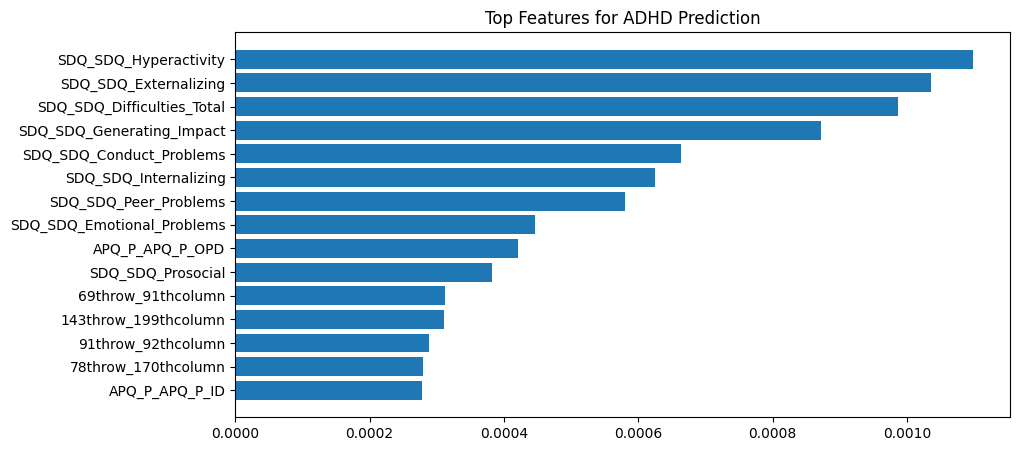

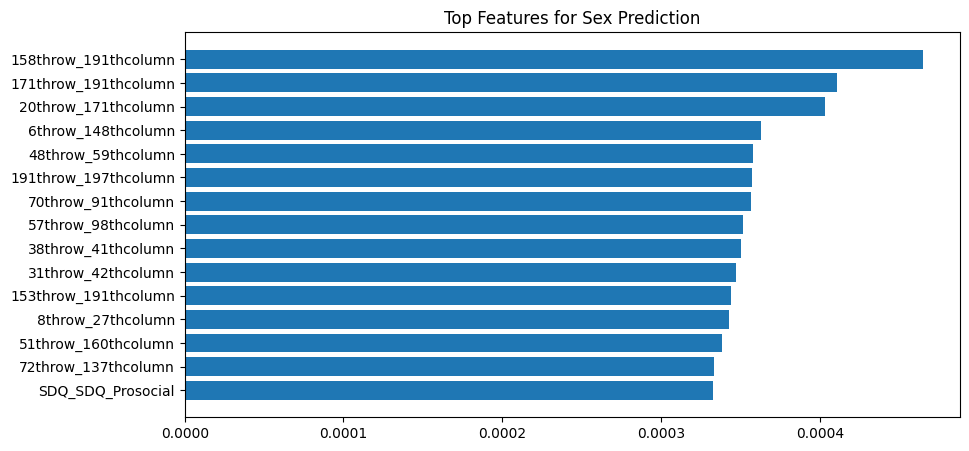

In [179]:
def compute_feature_importance(model, X_batch, target_class=0):
    """
    Computes average absolute gradients of input features with respect to output
    target_class: 0 for ADHD, 1 for Sex
    """
    model.eval()
    X_batch = torch.tensor(X_batch, dtype=torch.float32, requires_grad=True).to(next(model.parameters()).device)

    out_adhd, out_sex = model(X_batch)
    output = out_adhd if target_class == 0 else out_sex

    # We take the mean of outputs to get a single scalar
    output = output.mean()
    output.backward()

    importance = X_batch.grad.abs().mean(dim=0).cpu().numpy()
    return importance

# Choose a sample batch from validation
X_sample = X_val[:256]

# ADHD importance
adhd_importance = compute_feature_importance(model, X_sample, target_class=0)
sex_importance = compute_feature_importance(model, X_sample, target_class=1)

# Create DataFrame for top features
importances_df = pd.DataFrame({
    "Feature": feature_cols,
    "ADHD_Importance": adhd_importance,
    "Sex_Importance": sex_importance
}).sort_values("ADHD_Importance", ascending=False)

import matplotlib.pyplot as plt

top_k = 15
top_adhd = importances_df.sort_values("ADHD_Importance", ascending=False).head(top_k)
top_sex = importances_df.sort_values("Sex_Importance", ascending=False).head(top_k)

plt.figure(figsize=(10, 5))
plt.barh(top_adhd["Feature"], top_adhd["ADHD_Importance"])
plt.title("Top Features for ADHD Prediction")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(top_sex["Feature"], top_sex["Sex_Importance"])
plt.title("Top Features for Sex Prediction")
plt.gca().invert_yaxis()
plt.show()

### #14. t-SNE Visualization

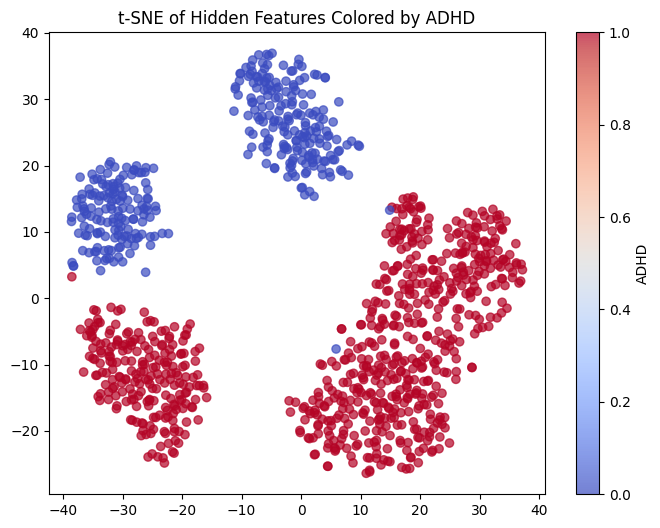

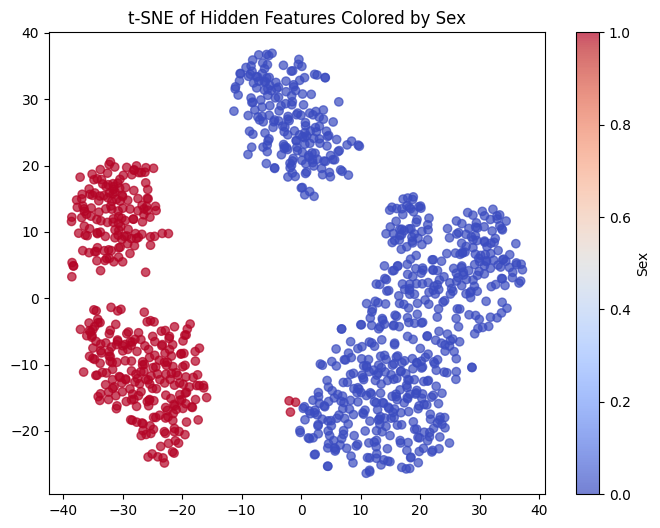

In [182]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, X, labels, label_name="Label"):
    model.eval()
    with torch.no_grad():
        features = model.net(torch.tensor(X, dtype=torch.float32).to(next(model.parameters()).device)).cpu().numpy()

    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca")
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
    plt.title(f"t-SNE of Hidden Features Colored by {label_name}")
    plt.colorbar(scatter, label=label_name)
    plt.show()

# Example usage:
plot_tsne(model, X_train, y_train_adhd.values, label_name="ADHD")
plot_tsne(model, X_train, y_train_sex.values, label_name="Sex")